## Generate PTPRC CITE-seq vs. MAS-seq validation plots

**Inputs and Outputs**
- Inputs:
  - long-reads adata object for M132TS incl. CITE-seq data (raw)
  - manual (decision-tree-based) annotations of PTPRC
- Outputs:
  - Figures

In [1]:
import os
import sys

import matplotlib.pylab as plt
import colorcet as cc
import numpy as np
import pandas as pd
from time import time
import logging
import pickle
import gffutils
import pysam
import umap
import scanpy as sc
import pickle

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.style.use('dark_background')

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = print

sc.set_figure_params(dpi=80)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'

# inputs
input_prefix = 'M132TS_immune.v4.harmonized'
output_path = 'output/t-cell-vdj-cite-seq'
final_long_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.raw.h5ad')

# manual isoform annotation quant
manual_adata_long_annotation_quants_path = os.path.join(repo_root, 'output/t-cell-vdj-cite-seq/manual_annotations')

In [3]:
adata_long_raw = sc.read(final_long_adata_raw_h5_path)

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


In [4]:
from scipy.sparse import hstack as sparse_hstack

def extend_adata(old_adata: sc.AnnData, new_adata: sc.AnnData) -> sc.AnnData:

    old_barcodes = old_adata.obs.index.values
    old_X = old_adata.X
    new_barcodes = new_adata.obs.index.values
    new_X = new_adata.X

    new_barcodes_to_idx_map = {barcode: idx for idx, barcode in enumerate(new_barcodes)}
    assert all(barcode in new_barcodes_to_idx_map for barcode in set(old_barcodes))
    kept_new_barcode_indices = list(map(new_barcodes_to_idx_map.get, old_barcodes))
    new_X_kept = new_X[kept_new_barcode_indices, :]

    merged_var = pd.concat((old_adata.var, new_adata.var))
    try:
        merged_X = sparse_hstack((old_X, new_X_kept)).tocsr()
    except:
        merged_X = np.hstack((old_X, new_X_kept)).copy()

    merged_adata = sc.AnnData(
        X=merged_X,
        obs=old_adata.obs,
        var=merged_var,
        uns=old_adata.uns,
        obsm=old_adata.obsm)
    
    return merged_adata

In [5]:
# extend adata with manual annotations
for dirname, _, filenames in os.walk(manual_adata_long_annotation_quants_path):
    for filename in filenames:
        manual_adata_long_path = os.path.join(dirname, filename)
        log_info(f'Adding manual isoform annotations from {manual_adata_long_path} ...')
        if manual_adata_long_path.split('.')[-1] != 'h5ad':
            continue
        manual_adata_long = sc.read(manual_adata_long_path)
        adata_long_raw = extend_adata(adata_long_raw, manual_adata_long)
adata_long_raw.X = adata_long_raw.X.tocsr()

Adding manual isoform annotations from /home/jupyter/mb-ml-data-disk/MAS-seq-analysis/output/t-cell-vdj-cite-seq/manual_annotations/adata_long_manual__PTPRC.h5ad ...


In [6]:
# ... or select isoforms manually
transcript_names = [
    'manual__PTPRC_ABC',
    'manual__PTPRC_BC',
    'manual__PTPRC_AB',
    'manual__PTPRC_B',
    'manual__PTPRC_O',
]

transcript_names_in_fig = [
    'CD45RABC',
    'CD45RBC',
    'CD45RAB',
    'CD45RB',
    'CD45RO',
]

# genes to show total expression alongside the isoforms
gene_names = [
    'HNRNPLL',
]

In [7]:
def plot_embedding_leiden(
        adata: sc.AnnData,
        embedding_key: str,
        leiden_key: str,
        markersize=2,
        alpha=0.75,
        xlabel='UMAP1',
        ylabel='UMAP2',
        label_kwargs=dict(bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)),
        x_offset=dict(),
        y_offset=dict(),
        fig=None,
        ax=None,
        show_labels=True,
        figsize=(3, 3)):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    leiden_color_key = f'{leiden_key}_colors'
    assert leiden_color_key in set(adata.uns.keys())

    leiden_category_to_leiden_color_map = {
        leiden_category: leiden_color
        for leiden_color, leiden_category in zip(
            adata.uns[leiden_color_key],
            adata.obs[leiden_key].values.categories)}
    cell_color_list = list(
        map(leiden_category_to_leiden_color_map.get, adata.obs[leiden_key]))

    ax.scatter(
        adata.obsm[embedding_key][:, 0],
        adata.obsm[embedding_key][:, 1],
        color=cell_color_list,
        s=markersize,
        alpha=alpha)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_labels:
        for leiden_category in adata.obs[leiden_key].values.categories:
            try:
                dx = x_offset[leiden_category]
                dy = y_offset[leiden_category]
            except KeyError:
                dx = 0
                dy = 0
            x_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 0] + dx
            y_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 1] + dy
            x_c, y_c = np.mean(x_values), np.mean(y_values)
            ax.text(
                x_c, y_c, leiden_category,
                fontsize=8,
                ha='center',
                **label_kwargs)

In [8]:
def plot_embedding_continuous(
        adata: sc.AnnData,
        embedding_key: str,
        values: np.ndarray,
        cmap=plt.cm.Blues,
        markersize=2,
        alpha=0.75,
        xlabel='UMAP1',
        ylabel='UMAP2',
        fig=None,
        ax=None,
        sort=True,
        figsize=(3, 3),
        **kwargs):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    if sort:
        order = np.argsort(values)
    else:
        order = np.arange(len(values))
    scatter = ax.scatter(
        adata.obsm[embedding_key][order, 0],
        adata.obsm[embedding_key][order, 1],
        c=values[order],
        cmap=cmap,
        s=markersize,
        alpha=alpha,
        **kwargs)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return scatter

In [9]:
import matplotlib

highlight = '#ff0000'

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'test',
    ['#dcdcdc', '#dcdcdc', highlight])

cmap_1 = matplotlib.colors.LinearSegmentedColormap.from_list(
    'test',
    ['#dcdcdc', highlight])

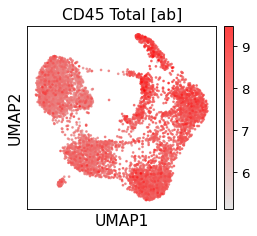

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(3.3, 3))

scatter = plot_embedding_continuous(
    adata_long_raw,
    'X_umap_SCT_short',
    values=adata_long_raw.obs['CD45_TotalSeqC'],
    ax=ax,
    cmap=cmap_1,
    fig=fig)

ax.set_title('CD45 Total [ab]')
div = make_axes_locatable(ax)
color_axis = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=color_axis)
cbar.ax.tick_params(labelsize=12)

plt.savefig('./output/M132TS__UMAP__AB__CD45TOTAL.pdf', bbox_inches="tight")

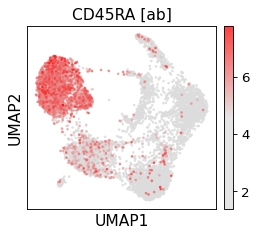

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(3.3, 3))

scatter = plot_embedding_continuous(
    adata_long_raw,
    'X_umap_SCT_short',
    values=adata_long_raw.obs['CD45RA_TotalSeqC'],
    ax=ax,
    cmap=cmap,
    fig=fig)

ax.set_title('CD45RA [ab]')
div = make_axes_locatable(ax)
color_axis = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=color_axis)
cbar.ax.tick_params(labelsize=12)

plt.savefig('./output/M132TS__UMAP__AB__CD45RA.pdf', bbox_inches="tight")

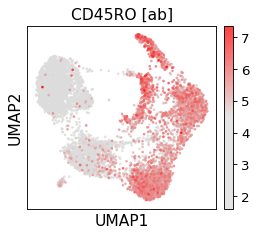

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(3.3, 3))

scatter = plot_embedding_continuous(
    adata_long_raw,
    'X_umap_SCT_short',
    values=adata_long_raw.obs['CD45RO_TotalSeqC'],
    ax=ax,
    cmap=cmap,
    fig=fig)

ax.set_title('CD45RO [ab]')
div = make_axes_locatable(ax)
color_axis = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=color_axis)
cbar.ax.tick_params(labelsize=12)

plt.savefig('./output/M132TS__UMAP__AB__CD45RO.pdf', bbox_inches="tight")

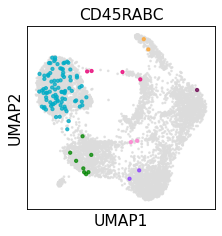

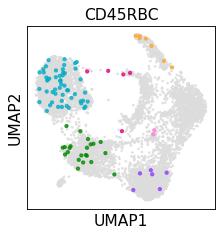

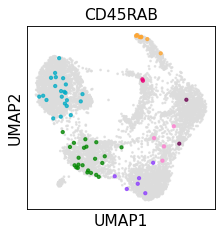

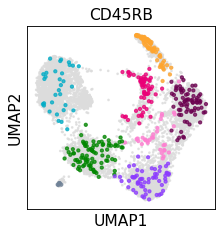

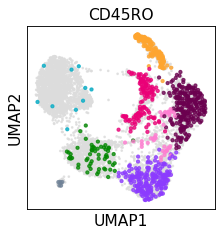

In [13]:
for idx in range(len(transcript_names)):

    transcript_name = transcript_names[idx]
    transcript_label = transcript_names_in_fig[idx]

    fig, ax = plt.subplots(figsize=(3, 3))

    adata_gray = adata_long_raw.copy()
    adata_gray.uns['mehrtash_leiden_colors'] = ['#dcdcdc'] * len(adata_gray.uns['mehrtash_leiden_colors'])

    plot_embedding_leiden(
        adata_gray,
        'X_umap_SCT_short',
        'mehrtash_leiden',
        show_labels=False,
        ax=ax,
        fig=fig
    )

    plot_embedding_leiden(
        adata_long_raw[np.asarray(adata_long_raw[:, transcript_name].X.todense()).flatten() > 0, :],
        'X_umap_SCT_short',
        'mehrtash_leiden',
        ax=ax,
        fig=fig,
        markersize=8,
        show_labels=False)

    ax.set_title(transcript_label)

    plt.savefig(f'./output/M132TS__UMAP__CD45__mRNA__{transcript_label}.pdf', bbox_inches="tight")

In [14]:
adata_long_norm = adata_long_raw.copy()
sc.pp.log1p(adata_long_norm)

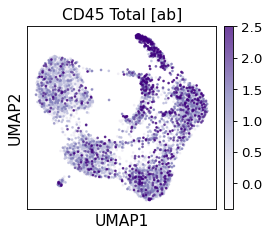

In [15]:
values = np.asarray(
    adata_long_norm[:, adata_long_norm.var['gencode_overlap_gene_names'] == 'PTPRC'].X.sum(-1)).flatten()

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(3.3, 3))

scatter = plot_embedding_continuous(
    adata_long_raw,
    'X_umap_SCT_short',
    values=values,
    ax=ax,
    vmin=-0.4,
    vmax=2.5,
    cmap=plt.cm.Purples,
    fig=fig)

ax.set_title('CD45 Total [ab]')
div = make_axes_locatable(ax)
color_axis = div.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(scatter, cax=color_axis)
cbar.ax.tick_params(labelsize=12)

plt.savefig('./output/M132TS__UMAP__CD45__mRNA__TOTAL.pdf', bbox_inches="tight")